<a href="https://colab.research.google.com/github/agalvezm/ACE2_scRNAseq/blob/master/notebooks_countmatrices/template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# define the values for the analysis

# accession id for the data
id = "GSE"

# If only bam available files, set bam = True, Fill the link for the bam file
bam = True
link_to_bam = "ftp://ftp.sra.ebi.ac.uk/vol1/SRA678/SRA678017/bam/H17w_K1.bam"


# Write corresponding GSE here

In [ ]:
# install and import necessary software

# Install kb and scanpy
!pip -q install kb-python 
!pip -q install scanpy

import re
import os

# Downloading and converting bam files (if bam = True) (run)

In [ ]:
def bam_to_vars(link):
  '''
  Receives bam link as an input, returns python and bash variables
  necessary for downstream analysis.
  '''
  # Assigns the link to the variable BAM_LINK. To be used by wget
  %env BAM_LINK=$link

  # Extracts name of bam file to be downloaded. 
  bam_filename = re.search('(?<=/bam/).+', link)[0]

  # Store it in bash variable. Used to remove bam file after converstion to fastq
  %env BAM_FILENAME=$bam_filename
  # Return link as python variable. 

In [ ]:
 bam_to_vars(link_to_bam)

if bam:

  # Install bamtofastq from 10x website (only bam files available)
  !wget http://cf.10xgenomics.com/misc/bamtofastq-1.2.0
  !chmod +x bamtofastq-1.2.0
  # Download the bam file
  !wget -- continue ${BAM_LINK}




env: BAM_LINK=ftp://ftp.sra.ebi.ac.uk/vol1/SRA678/SRA678017/bam/H17w_K1.bam
env: BAM_FILENAME=H17w_K1.bam


In [ ]:
# Convert to fastq
!./bamtofastq-1.2.0 --reads-per-fastq=500000000 ${BAM_FILENAME} ./fastqs\

# Remove original bam file to save space
!rm ${BAM_FILENAME}


bamtofastq v1.2.0
Args { arg_bam: "H17w_K1.bam", arg_output_path: "./fastqs", flag_nthreads: 4, flag_locus: None, flag_bx_list: None, flag_reads_per_fastq: 500000000, flag_gemcode: false, flag_lr20: false, flag_cr11: false }
Writing finished.  Observed 242522743 read pairs. Wrote 242522743 read pairs


In [ ]:
# Store fastq names on a list

# cd into fastqs folder
%cd /content/fastqs

#store the name of the folder generated by bamtofastq
_filename = os.listdir()[0]

# cd into that folder
%cd $_filename

# store fastq names in a list
fastqs = os.listdir()


# Remove I1 and R3 reads not relevant for our analysis

print ("\n\nThis is the complete list of fastqs:\n -----------")
for elem in fastqs:
  print (elem)

if bam == True:
  for elem in fastqs:
    if re.search("_R3_", elem) or re.search("_I1_", elem):
      fastqs.remove(elem)



print ("\n\nThis is the filtered list of fastqs:\n -----------")
for elem in fastqs:
  print (elem)


/content/fastqs
/content/fastqs/H17w_K1_MissingLibrary_1_HJHKCBGX5


This is the complete list of fastqs:
 -----------
yetanothertest.h5ad
bamtofastq_S1_L001_I1_001.fastq.gz
index.idx
output
bamtofastq_S1_L001_R1_001.fastq.gz
bamtofastq_S1_L001_R2_001.fastq.gz
t2g.txt


This is the filtered list of fastqs:
 -----------
yetanothertest.h5ad
index.idx
output
bamtofastq_S1_L001_R1_001.fastq.gz
bamtofastq_S1_L001_R2_001.fastq.gz
t2g.txt


# Define list of fastq links (if bam = False) (edit)

In [ ]:
if not bam:
  fastqs = ["",
            "",
            ]


# ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR645/007/SRR6459187/SRR6459187.fastq.gz
# ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR645/008/SRR6459188/SRR6459188.fastq.gz
# ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR645/009/SRR6459189/SRR6459189.fastq.gz
# ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR645/000/SRR6459190/SRR6459190.fastq.gz
# ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR645/001/SRR6459191/SRR6459191.fastq.gz
# ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR645/002/SRR6459192/SRR6459192.fastq.gz
# ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR645/003/SRR6459193/SRR6459193.fastq.gz
# ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR645/004/SRR6459194/SRR6459194.fastq.gz
# ftp://ftp.sra.ebi.ac.uk/vol1/SRA645/SRA645804/bam/AdultHuman_Spermatocytes_17_11_possorted_genome_bam.bam
# ftp://ftp.sra.ebi.ac.uk/vol1/SRA645/SRA645804/bam/AdultHuman_Spermatids_17_11_possorted_genome_bam.bam

In [ ]:
quit()

# Writing metadata (edit)

In [ ]:
fastqs

['bamtofastq_S1_L001_R1_001.fastq.gz', 'bamtofastq_S1_L001_R2_001.fastq.gz']

In [ ]:
no_samples = 1

database_id = ["GSE"] * no_samples

tissue = ["lung"] * no_samples

cell_type = ["none"] * no_samples

sample_id = ["GSM"] * no_samples

condition = ["none"] * no_samples

species = ["human"] * no_samples

technology = ["10xv2"] * no_samples

paper = ["Muus et al 2020"] * no_samples

figure = ["Fig"] * no_samples


# Set string variables for kb functions

species_kb = species[0]

technology_kb = technology[0]




In [ ]:
# Manually correct the relevant lists if necessary:




# Download Kallisto index (run)

In [ ]:
if bam:
  # Download the corresponding Kallisto index to folder containing fastqs
  !kb ref -d $species_kb -i index.idx -g t2g.txt -f1 transcriptome.fasta

if not bam:
  %cd /content

  # Download the corresponding Kallisto index to content folder
  !kb ref -d $species_kb -i index.idx -g t2g.txt -f1 transcriptome.fasta

[2020-09-23 20:58:42,485]    INFO Downloading files for human from https://caltech.box.com/shared/static/v1nm7lpnqz5syh8dyzdk2zs8bglncfib.gz to tmp/v1nm7lpnqz5syh8dyzdk2zs8bglncfib.gz
[2020-09-23 21:00:29,694]    INFO Extracting files from tmp/v1nm7lpnqz5syh8dyzdk2zs8bglncfib.gz


# Processing fastq files (select from list)

In [ ]:
print(fastqs)

['bamtofastq_S1_L001_R1_001.fastq.gz', 'bamtofastq_S1_L001_R2_001.fastq.gz']


In [ ]:
#Specify the sample number you are analyzing

samp_n = 0

# Write the kb count command as a string
cmd = "kb count --h5ad -i index.idx -g t2g.txt -x " + technology_kb + " -o output\
 --filter bustools -t 2 --overwrite " +\
      fastqs[0] + " " + fastqs[1]
# Execute it

!$cmd




[2020-09-23 21:01:15,821]    INFO Generating BUS file from
[2020-09-23 21:01:15,821]    INFO         bamtofastq_S1_L001_R1_001.fastq.gz
[2020-09-23 21:01:15,821]    INFO         bamtofastq_S1_L001_R2_001.fastq.gz
[2020-09-23 21:45:45,460]    INFO Sorting BUS file output/output.bus to tmp/output.s.bus
[2020-09-23 21:48:32,281]    INFO Whitelist not provided
[2020-09-23 21:48:35,540]    INFO Copying pre-packaged 10XV2 whitelist to output
[2020-09-23 21:48:37,093]    INFO Inspecting BUS file tmp/output.s.bus
[2020-09-23 21:49:09,433]    INFO Correcting BUS records in tmp/output.s.bus to tmp/output.s.c.bus with whitelist output/10xv2_whitelist.txt
[2020-09-23 21:49:53,911]    INFO Sorting BUS file tmp/output.s.c.bus to output/output.unfiltered.bus
[2020-09-23 21:51:29,901]    INFO Generating count matrix output/counts_unfiltered/cells_x_genes from BUS file output/output.unfiltered.bus
[2020-09-23 21:51:52,797]    INFO Converting matrix output/counts_unfiltered/cells_x_genes.mtx to h5ad out

## Load the unfiltered matrix (check dimensions)

In [ ]:
# Setup

import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as sc
from scipy import stats

from collections import OrderedDict
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from matplotlib import cm
from matplotlib.lines import Line2D

def nd(arr):
    return np.asarray(arr).reshape(-1)
def yex(ax):
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]),
            np.max([ax.get_xlim(), ax.get_ylim()])]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

import warnings
warnings.filterwarnings('ignore')

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'



In [ ]:
# load the unfiltered matrix
adata = anndata.read_h5ad("output/counts_unfiltered/adata.h5ad")
adata.var["gene_id"] = adata.var.index.values

t2g = pd.read_csv("t2g.txt", header=None, names=["tid", "gene_id", "gene_name"], sep="\t")
t2g.index = t2g.gene_id
t2g = t2g.loc[~t2g.index.duplicated(keep='first')]

adata.var["gene_name"] = adata.var.gene_id.map(t2g["gene_name"])
adata.var.index = adata.var["gene_name"]
print("The unfiltered matrix contains {} cells by {} genes".format(len(adata.obs), len(adata.var)))

The unfiltered matrix contains 321303 cells by 60623 genes


In [ ]:
adata.obs["cell_counts"] = adata.X.sum(axis=1)
adata.var["gene_counts"] = nd(adata.X.sum(axis=0))

adata.obs["n_genes"] = nd((adata.X>0).sum(axis=1))
adata.var["n_cells"] = nd((adata.X>0).sum(axis=0))

mito_genes = adata.var_names.str.startswith("MT-" or "mt-") 
adata.obs["percent_mito"] = adata[:,mito_genes].X.sum(axis=1)/adata.X.sum(axis=1)*100

# Changing the name of the index is necessary to write the file (it won't work with duplicated names)
adata.var.index.name = "index"

## Populate the anndata object (run both individually)

### Filter low UMIs

In [ ]:
# Filtering criteria
cell_threshold = 100
gene_threshold = 3

mito_criteria = 30



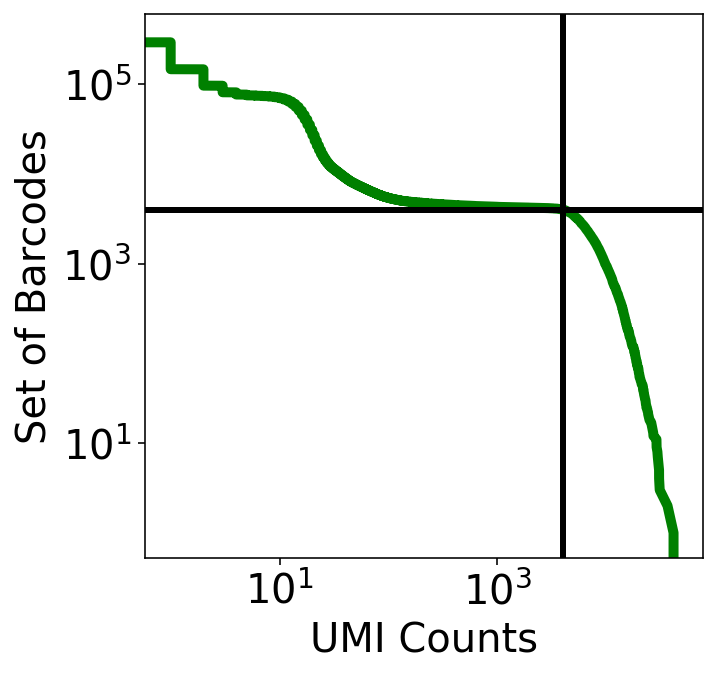

In [ ]:
#@title Threshold cells according to knee plot { run: "auto", vertical-output: true }
expected_num_cells = 4000#@param {type:"integer"}
knee = np.sort(nd(adata.X.sum(axis=1)))[::-1]

fig, ax = plt.subplots(figsize=(5, 5))

x = knee
y = range(len(knee))

ax.loglog(x, y, linewidth=5, color="g")

ax.axvline(x=knee[expected_num_cells], linewidth=3, color="k")
ax.axhline(y=expected_num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.show()

In [ ]:
quit()

In [ ]:
# Define cell threshold according to plot

cell_threshold = knee[expected_num_cells]
print ("Cells were filtered down to " + str(expected_num_cells) + " with at least " + str(cell_threshold) + " UMIs")

Cells were filtered down to 4000 with at least 4010.0 UMIs


### Filter by mitochondrial content

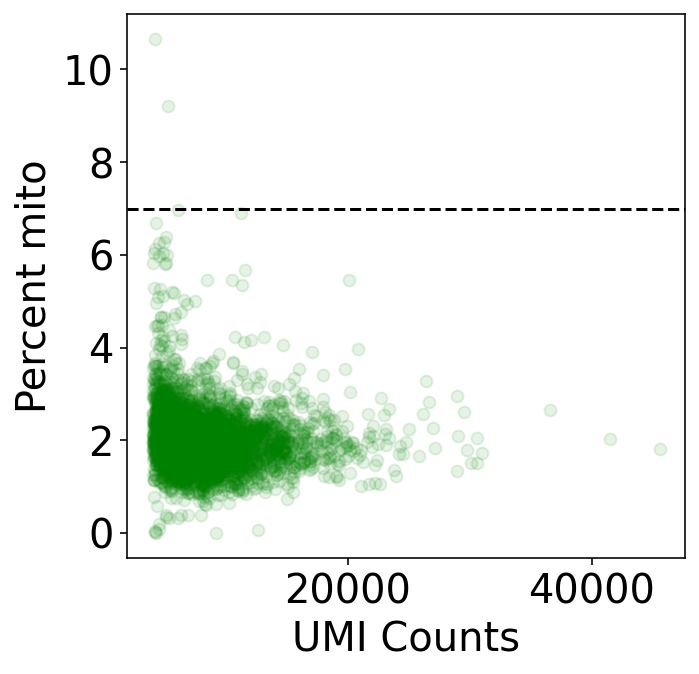

We select 7 % as the mitochondrial content threshold


In [ ]:
mito_criteria = 7#@param {type:"integer"}

fig, ax = plt.subplots(figsize=(5,5))


x = nd(adata.obs["cell_counts"][adata.obs["cell_counts"] > cell_threshold])
y = nd(adata.obs["percent_mito"][adata.obs["cell_counts"] > cell_threshold])

ax.scatter(x, y, color="green", alpha=0.1)

ax.axhline(y=mito_criteria, linestyle="--", color="k")


ax.set_xlabel("UMI Counts")
ax.set_ylabel("Percent mito")


plt.show()

print("We select " + str(mito_criteria) + " % as the mitochondrial content threshold")

## Filter the Anndata object

In [ ]:
adata.obs["pass_count_filter"] = adata.obs["cell_counts"] > cell_threshold
adata.obs["pass_mito_filter"] = adata.obs.percent_mito < mito_criteria
adata.var["pass_gene_filter"] = adata.var["n_cells"] > gene_threshold

cell_mask = np.logical_and(adata.obs["pass_count_filter"].values, adata.obs["pass_mito_filter"].values)
gene_mask = adata.var["pass_gene_filter"].values

print("Current Shape: {:,} cells x {:,} genes".format(adata.shape[0], adata.shape[1]))
print("    New shape: {:,} cells x {:,} genes".format(cell_mask.sum(), gene_mask.sum()))

Current Shape: 321,303 cells x 60,623 genes
    New shape: 5,295 cells x 29,972 genes


In [ ]:
data = adata[cell_mask, gene_mask]

## Anotate the Anndata object

In [ ]:
data.uns["database_id"] = database_id[samp_n]

data.uns["tissue"] = tissue[samp_n]

data.uns["cell_type"] = cell_type[samp_n]

data.uns["sample_id"] = sample_id[samp_n]

data.uns["condition"] = condition[samp_n]

data.uns["species"] = species[samp_n]

data.uns["technology"] = technology[samp_n]

data.uns["paper"] = paper[samp_n]

data.uns["figure"] = figure[samp_n]

Trying to set attribute `.uns` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


# Write the Anndata object

In [ ]:
data.write("result" + str(samp_n + 1))

... storing 'gene_name' as categorical
